In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def value_iteration_for_gamblers(p_h, theta=0.0001, discount_factor=1.0):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    rewards = np.zeros(101)
    rewards[100] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros(101)
    
    def one_step_lookahead(s, V, rewards):
        """
        Calculate the value for all action in a given state.
        """
        A = np.zeros(101)
        stakes = range(1, min(s, 100-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        for a in stakes:
            # rewards[s+a], rewards[s-a] are immediate rewards.
            # V[s+a], V[s-a] are values of the next states.
            # This is the core of the Bellman equation: The expected value of your action is 
            # the sum of immediate rewards and the value of the next state.
            A[a] = p_h * (rewards[s+a] + V[s+a]*discount_factor) + (1-p_h) * (rewards[s-a] + V[s-a]*discount_factor)
        return A
    
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(1, 100):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V, rewards)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function.
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros(100)
    for s in range(1, 100):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V, rewards)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s] = best_action
    
    return policy, V

In [3]:
nonrobust_opt_policy, nonrobust_opt_v = value_iteration_for_gamblers(0.6)

print("Optimized Policy:")
print(nonrobust_opt_policy)

print("Optimized Value Function:")
print(nonrobust_opt_v)

Optimized Policy:
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Optimized Value Function:
[0.         0.33187815 0.55320397 0.70084426 0.79936858 0.86515101
 0.9091039  0.93849981 0.9581857  0.97139209 0.98027239 0.98626215
 0.99031861 0.9930802  0.99497294 0.99628122 0.99719506 0.99784156
 0.99830584 0.99864503 0.99889757 0.9990894  0.99923812 0.99935575
 0.99945054 0.99952821 0.9995928  0.99964717 0.9996934  0.99973301
 0.99976716 0.99979676 0.99982237 0.99984461 0.9998639  0.99988069
 0.99989531 0.99990805 0.99991918 0.99992891 0.99993742 0.99994487
 0.99995141 0.99995716 0.99996221 0.99996665 0.99997056 0.99997401
 0.99997706 0.99997974 0.99998212 0.99998421 0.99998607 0.99998771
 0.99998916 0.99999044 0.99999158 0.99999259 0.

# generative sampling

In [13]:
def empirical_est(p_h,n=20):
    
    ns = [0, 1] # == s+a, s-a states
    data = np.random.choice(ns, n, p = [p_h, 1-p_h])
    
    est_p = [len(np.where(data == 0)[0])*1.0/n,
             len(np.where(data == 1)[0])*1.0/n,]
    
    return est_p

# l1 and chi2 ambiguity

In [121]:
from numpy import ma
from scipy.optimize import minimize

flag=input("\nEnter '1' for l1 uncertainty set or '2' for chi2 uncertainty set.\n")


if flag=="1":          


    def worstcase_l1(v,q,t):
        """
        o = worstcase_l1(v,q,t)

        Computes the solution of:
        min_p   p^T * v
        s.t.    \|p,q\|_1 <= t
        via it's Dual formulation

        where o is the objective value

        Notes
        -----

        """
        if t == 0:
            return np.dot(q,v)
        if t < 0:
            raise ValueError('Bound t must be greater than 0.')
        if q.dtype != float:
            raise ValueError('Value q must be a float array.')    

        S = len(v)

        fun = lambda x: np.dot(q,x) + (t/2) * ( np.max(v-x) - np.min(v-x) )
        cons = ({'type': 'ineq', 'fun': lambda x:  x},
    #             {'type': 'ineq', 'fun': lambda x:  v-x },
                 )
        x0 = np.random.rand(S)
    #     x0 /= np.sum(x0)

        res = minimize(fun, x0, method='SLSQP', constraints=cons,
                          tol=1e-3) #, options = {'disp': True})

        return np.dot(q,v) - res.fun
    
else:

    def worstcase_l1(v,q,t):
        """
        o = worstcase_l1(v,q,t)

        Computes the solution of:
        min_p   p^T * v
        s.t.    D_c(p,q) <= t
        via it's Dual formulation

        where o is the objective value

        Notes
        -----

        """
        if t == 0:
            return np.dot(q,v)
        if t < 0:
            raise ValueError('Bound t must be greater than 0.')
        if q.dtype != float:
            raise ValueError('Value q must be a float array.')    

        S = len(v)

        fun = lambda x: np.dot(q,x) + np.sqrt(t * ( np.dot(q,(v-x)**2) - (np.dot(q,(v-x)))**2))
        cons = ({'type': 'ineq', 'fun': lambda x:  x},
    #             {'type': 'ineq', 'fun': lambda x:  v-x },
                 )
        x0 = np.random.rand(S)
    #     x0 /= np.sum(x0)

        res = minimize(fun, x0, method='SLSQP', constraints=cons, #bounds=bnds,
                          tol=1e-3) #, options = {'disp': True})

        return np.dot(q,v) - res.fun

# Robust VI algorithm

In [124]:
def robust_vi_for_gamblers(p_h, max_states_plus_1 = 100, theta=1e-4, 
                           discount_factor=1.0, c_r=0.2, max_iteration=100, uncer='l1',
                           num_samp=40):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    with_dummy_states = max_states_plus_1 + 1
    rewards = np.zeros(with_dummy_states)
    rewards[max_states_plus_1] = 1 
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros(with_dummy_states)
    
    def one_step_lookahead(s, V, rewards, c_r=0.2):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(with_dummy_states)
        stakes = range(1, min(s, max_states_plus_1-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        for a in stakes:
            # rewards[s+a], rewards[s-a] are immediate rewards.
            # V[s+a], V[s-a] are values of the next states.
            # Robust Bellman equation:
            z = [rewards[s+a] + V[s+a]*discount_factor, rewards[s-a] + V[s-a]*discount_factor]
            if uncer=='l1':
                A[a] = worstcase_l1(np.array(z), np.array([p_h, 1-p_h]), c_r)
            elif uncer=='l1hat':
                est_p = empirical_est(p_h,n=num_samp)
                A[a] = worstcase_l1(np.array(z), np.array(est_p), c_r)
        return A
    
    itera = 1
    vf_collect = np.zeros((max_iteration,with_dummy_states))
    while itera <= max_iteration:
        if itera%10==0:
            print("VI iters done : ", itera)
        itera += 1
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(1, max_states_plus_1):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V, rewards, c_r)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        vf_collect[itera-2,:] = V
        if delta < theta:
            break
    
    lastvk_robopt_diff = -1
    if uncer=='l1hat':
        temp=np.zeros_like(vf_collect[0:itera-1,:])
        temp[:,]=robust_opt_v_l1
        temp1 = abs(vf_collect[0:itera-1,:]-temp)
        v_k_robopt_diff = temp1.max(axis=1)
        lastvk_robopt_diff = v_k_robopt_diff[-1]

#         ### LEARNING CURVE save data
#         np.savetxt('gambler_l1_cr_0.2_learning.csv', (range(1,itera), v_k_robopt_diff),\
#                                        delimiter=',')
        #### Temporary plot
#         plt.figure()
        plt.plot(range(1,itera),v_k_robopt_diff)
        plt.ylabel(r'$||V_k-V^*||$')
        plt.xlabel('iteration k')
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros(max_states_plus_1)
    for s in range(1, max_states_plus_1):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V, rewards, c_r)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s] = best_action
    
    return policy, V, lastvk_robopt_diff

# robust VI with P^o + l1/chi2

In [131]:
robust_opt_policy_l1, robust_opt_v_l1, _ = robust_vi_for_gamblers(0.6, max_iteration=200, c_r = 0.2, uncer='l1')

print("Optimized Policy:")
print(robust_opt_policy_l1)

print("Optimized Value Function:")
print(robust_opt_v_l1)

VI iters done :  10
Optimized Policy:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 23. 24. 25. 26. 27. 28.
 29.  7.  6. 32. 33. 34. 35. 36. 37. 13. 14. 16. 16.  5. 18. 20.  8. 21.
 10.  1. 24. 25. 14. 15.  3. 17.  6.  6.  8. 15.  2.  4.  5. 12.  2.  3.
  1.  5.  6.  6.  5.  3.  2.  1.  1.  1.]
Optimized Value Function:
[0.         0.00999999 0.02       0.03       0.04       0.05
 0.06       0.07       0.08       0.09       0.1        0.11
 0.12       0.13       0.14       0.15       0.16       0.17
 0.18       0.19       0.2        0.21       0.22       0.23
 0.24       0.25       0.26       0.27       0.28       0.29
 0.3        0.31       0.32       0.33       0.34       0.35
 0.36       0.37       0.38       0.39       0.4        0.41
 0.42       0.43       0.44       0.45       0.46       0.47
 0.48       0.49       0.5        0.51   

# robust VI with \hat{P} + l1/chi2

Optimized Policy:
[ 0.  1.  2.  3.  4.  5.  6.  6.  7.  4.  3.  2.  8. 12. 11.  9.  3.  4.
 11.  6.  7.  4.  9. 12.  4. 12.  7. 11. 11. 25. 25.  4.  4.  4. 12. 13.
  8.  9. 10.  9.  1.  4.  6. 12.  4.  3.  2. 10. 14.  1.  2. 19.  4.  4.
  1.  7.  8.  9.  8. 13.  8.  1. 20.  9. 16.  6.  7. 15. 17.  3.  2.  5.
  6.  1.  2.  4.  4.  6.  3.  3.  2.  9.  3.  1.  5.  3.  4.  1.  9.  1.
  2.  3.  4.  5.  4.  2.  1.  1.  2.  1.]
Optimized Value Function:
[0.         0.00856798 0.02004463 0.03244832 0.04307605 0.05443473
 0.06567485 0.07727447 0.08729028 0.09810862 0.10960822 0.11970742
 0.13104141 0.14445318 0.15345677 0.16345985 0.17408758 0.18593084
 0.1971702  0.20741949 0.21858245 0.22962663 0.24037017 0.25021846
 0.26159314 0.27367496 0.28324058 0.29464646 0.30507385 0.31523338
 0.32527285 0.33576518 0.34740584 0.35805614 0.36759459 0.3784624
 0.38852477 0.39973972 0.40938122 0.42008583 0.43019909 0.44077361
 0.45156707 0.4603708  0.47136733 0.48247064 0.49126279 0.50096018
 0.51449362 0.

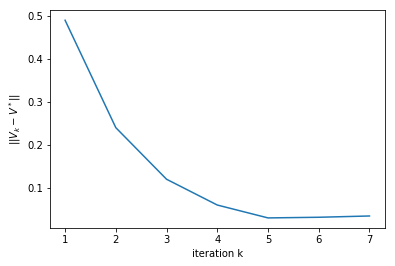

In [125]:
robust_hat_policy_l1, robust_hat_v_l1, _ = robust_vi_for_gamblers(0.6, max_iteration=200, c_r = 0.2, theta=1e-2,
                                                               uncer='l1hat', num_samp=5000)

print("Optimized Policy:")
print(robust_hat_policy_l1)

print("Optimized Value Function:")
print(robust_hat_v_l1)

# Performance N curve

seed -  0
VI iters done :  10
VI iters done :  20
VI iters done :  30
VI iters done :  40
VI iters done :  10
seed -  1
VI iters done :  10
VI iters done :  20
VI iters done :  30
VI iters done :  40
VI iters done :  50
VI iters done :  60
VI iters done :  70
VI iters done :  80
VI iters done :  90
VI iters done :  100
VI iters done :  10
seed -  2
VI iters done :  10
VI iters done :  20
VI iters done :  30
VI iters done :  40
VI iters done :  50
VI iters done :  10
seed -  3
VI iters done :  10
VI iters done :  20
VI iters done :  30
VI iters done :  40
VI iters done :  50
VI iters done :  60
VI iters done :  70
VI iters done :  10
seed -  4
VI iters done :  10
VI iters done :  20
VI iters done :  30
VI iters done :  40
VI iters done :  50
VI iters done :  10
seed -  5
VI iters done :  10
VI iters done :  20
VI iters done :  30
VI iters done :  40
VI iters done :  50
VI iters done :  10
seed -  6
VI iters done :  10
VI iters done :  20
VI iters done :  30
VI iters done :  40
VI iters 

Text(0,0.5,'value diff')

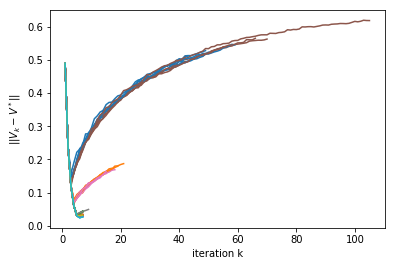

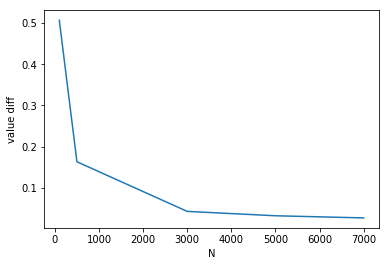

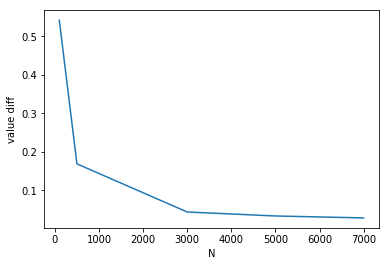

In [126]:
n_range = [100, 500, 3000, 5000, 7000]

s_range = range(10)
diff_seeds = np.zeros((len(s_range),len(n_range)))
pol_seed = []
for s in s_range:
    print("seed - ", s)
    diff_values = []
    pol = []
    for n in n_range:
        np.random.seed(s+n)
        temp_pol, _, diff = robust_vi_for_gamblers(0.6, max_iteration=200, c_r = 0.2, 
                                                    theta=1e-2, uncer='l1hat', num_samp=n)
        diff_values.append(diff)
        pol.append(temp_pol)
    diff_seeds[s,:] = diff_values
    pol_seed.append(pol)
    
plt.figure()
plt.plot(n_range,diff_values)
plt.xlabel("N")
plt.ylabel("value diff")

plt.figure()
plt.plot(n_range,np.mean(diff_seeds,axis=0))
plt.xlabel("N")
plt.ylabel("value diff")

[0.03172956 0.01009813 0.00208795 0.00084112 0.00089818]


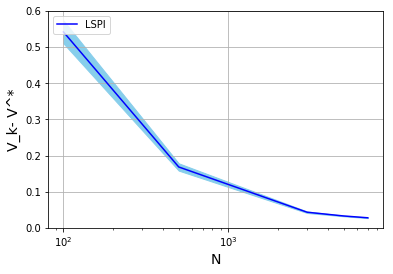

In [127]:
plt.figure()
mean_vals = np.mean(diff_seeds,axis=0)
std_vals = np.std(diff_seeds,axis=0)
print(std_vals)
plt.plot(n_range,mean_vals, color='b', label='LSPI')
plt.fill_between(n_range, mean_vals - std_vals, mean_vals + std_vals, color='skyblue' )
plt.xlabel("N",fontsize=14)
plt.ylabel("V_k- V^*",fontsize=14)
plt.legend(loc = 'upper left')
plt.grid()
plt.xscale('log')
plt.show()

# Uncomment this if you want to save data
# np.savetxt('gambler_l1_c_r_0.2_N_2.csv', (n_range, mean_vals, std_vals),\
#                                    delimiter=',')

# Performance of Robust vs non-robust policies

In [128]:
def gamblers_step(s, a, p_h, max_states_plus_1):
    if np.random.binomial(1, p_h, 1):
        ns = s + a
    else:
        ns = s - a
        
    if ns >= max_states_plus_1:
        return ns, 1
    else:
        return ns, 0

def run_policy(p_h, policy, max_states_plus_1 = 100, max_steps = 400):
    current_state = np.random.randint(1,max_states_plus_1-1)
    t = 1 
    while True:
        nextstate, reward = gamblers_step(current_state, policy[int(current_state)], p, max_states_plus_1)
#         print(nextstate, policy[int(current_state)])
        
        if nextstate == 0:
            return 0, t
        
        if t > max_steps or reward == 1:
            return reward, t

        current_state=nextstate
        t += 1
    

In [133]:
head_p = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7]
n_runs = 1000

    
s_range = range(10)
win_ratio_seeds = np.zeros((len(s_range),len(head_p),len(policies)))
for s in s_range:
    print("seed - ", s)
    policies = []
    # non-robust opt
    policies.append( nonrobust_opt_policy )
    # robust opt l1
    policies.append( robust_opt_policy_l1 )
    # robust policies for N samples in n_range 
    for j, _ in enumerate(n_range):
        policies.append( pol_seed[s][j] )
    win_percent_data = []
    for jj, p in enumerate(head_p):
        data_collect = []
        time_data_collect = []
        for n in range(n_runs):
            np.random.seed(np.random.randint(s+n+10))
            temp = []
            temp_2 = []
            for j in range(len(policies)):
                reward, steps_time = run_policy(p, policies[j], max_states_plus_1 = 100, max_steps = 500)
                temp.append(reward)
                temp_2.append(steps_time)
            data_collect.append(temp)
            time_data_collect.append(temp_2)

        win_percent = np.mean(data_collect, axis=0)
#         print(p)
#         print('winning percent: ')
#         print(win_percent)
#         print('*'*40)
        win_ratio_seeds[s,jj,:] = win_percent

seed -  0
seed -  1
seed -  2
seed -  3
seed -  4
seed -  5
seed -  6
seed -  7
seed -  8
seed -  9


In [135]:
mean_vals = np.mean(win_ratio_seeds,axis=0)
std_vals = np.std(win_ratio_seeds,axis=0)

# Note-to-self: High time I learn using panda!
head_p_with_mean_vals = np.zeros((mean_vals.shape[0],mean_vals.shape[1]+1))
head_p_with_mean_vals[:,0:mean_vals.shape[1]] = mean_vals
head_p_with_mean_vals[:,-1] = head_p

head_p_with_std_vals = np.zeros((mean_vals.shape[0],mean_vals.shape[1]+1))
head_p_with_std_vals[:,0:mean_vals.shape[1]] = std_vals
head_p_with_std_vals[:,-1] = head_p
# print(head_p_with_mean_vals)
# print(head_p_with_std_vals)


# Uncomment this if you want to save data
# np.savetxt('gambler_l1_c_r_0.2_test_performance_2.csv', (head_p_with_mean_vals.reshape(-1), head_p_with_std_vals.reshape(-1)),\
#                                    delimiter=',')

[[3.000e-04 7.930e-02 5.000e-04 2.000e-04 1.070e-02 2.150e-02 1.020e-02
  2.000e-01]
 [0.000e+00 1.498e-01 1.500e-03 7.100e-03 7.100e-03 3.660e-02 1.240e-02
  2.500e-01]
 [9.000e-04 2.236e-01 4.100e-03 8.000e-03 2.240e-02 4.430e-02 2.970e-02
  3.000e-01]
 [1.300e-03 2.320e-01 1.750e-02 2.620e-02 5.100e-02 6.320e-02 7.690e-02
  3.500e-01]
 [6.500e-03 2.736e-01 5.600e-02 8.100e-02 1.340e-01 1.324e-01 1.490e-01
  4.000e-01]
 [2.990e-02 4.486e-01 1.561e-01 2.217e-01 3.107e-01 3.039e-01 3.045e-01
  4.500e-01]
 [6.540e-01 6.005e-01 8.183e-01 7.578e-01 6.646e-01 6.344e-01 6.355e-01
  5.500e-01]
 [9.758e-01 5.691e-01 9.432e-01 9.157e-01 7.396e-01 7.643e-01 7.297e-01
  6.000e-01]
 [9.769e-01 6.429e-01 9.871e-01 9.282e-01 8.584e-01 8.438e-01 8.365e-01
  6.500e-01]
 [9.917e-01 7.651e-01 9.886e-01 9.797e-01 8.426e-01 8.650e-01 8.758e-01
  7.000e-01]]
[[9.00000000e-04 6.09328319e-02 1.50000000e-03 4.00000000e-04
  2.30740114e-02 5.46008242e-02 1.51512376e-02 2.00000000e-01]
 [0.00000000e+00 8.70710